# Google Trends EDA

## Set Up
Installing necessary packages and importing modules.

In [2]:
#make sure API package is installed, uncomment if not
#!pip install pytrends --user

import pandas as pd
import numpy as np
import time


#for plotting
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 10)

import plotly.express as px

#apis for data
from pytrends.request import TrendReq

#words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

Querying the API and making the list of terms we want searched.

In [36]:
pytrends = TrendReq()
artists = ["BTS", "Taylor Swift", "Justin Bieber"]

pytrends.build_payload(kw_list = artists, cat = 3, timeframe = 'all', geo = '')
#pytrends.build_payload(kw_list = artists, timeframe = 'all', geo = '')

Make list of the timeframes we're looking at for the hastag trends and album releases.

In [4]:
#make list of timeframes

hashtag_timeframes = ['2020-06-01 2020-06-18',
                      '2020-06-20 2020-07-04',
                      '2021-01-18 2021-02-01']

bts_timeframes = ['2014-08-17 2014-08-31',
                 '2018-05-16 2018-05-30',
                 '2020-11-18 2020-12-02']

ts_timeframes = ['2014-10-25 2014-11-08',
                '2017-11-08 2017-11-22',
                '2020-07-22 2020-08-05']

jb_timeframes = ['2012-06-13 2012-06-27',
                '2015-11-11 2015-11-25',
                '2020-02-12 2020-02-26']

music_timeframes = [bts_timeframes, ts_timeframes, jb_timeframes]

artist_albums = ['BTS', 'Taylor Swift', 'Justin Bieber']

### Time-Based Trend Data

Get the overall monthly trend data (monthly) from earliest start period possible.

In [37]:
overall_monthly = pytrends.interest_over_time()

overall_monthly.drop('isPartial', inplace = True, axis = 1)

overall_monthly.reset_index(inplace = True)

overall_monthly = overall_monthly.melt(id_vars = ['date'],
                    var_name = 'Artist',
                    value_name = 'Popularity')

overall_monthly.head()

,date,Artist,Popularity
0,2004-01-01,BTS,1
1,2004-02-01,BTS,1
2,2004-03-01,BTS,1
3,2004-04-01,BTS,1
4,2004-05-01,BTS,1


In [38]:
overall_monthly.groupby('Artist').agg({
    'Popularity': ['mean', 'median', pd.Series.mode, 'count',
                  'max', 'min', 'std', 'var', 'skew', pd.DataFrame.kurt]
})

Popularity                                                    \
                    mean median mode count  max min        std         var   
Artist                                                                       
BTS             3.637681      1    1   207   15   0   4.399816   19.358379   
Justin Bieber  18.173913     10    0   207   86   0  20.983551  440.309413   
Taylor Swift   25.797101     23    0   207  100   0  20.177787  407.143098   

                                   
                   skew      kurt  
Artist                             
BTS            1.157990 -0.204352  
Justin Bieber  1.290795  1.018173  
Taylor Swift   0.758213  0.331661

### Region-based Trend Data

In [8]:
#country codes
codes = px.data.gapminder().query("year==2007")[['country', 'iso_alpha']]

In [18]:
overall_regions = pytrends.interest_by_region()

overall_regions.columns.name = "Artist"
overall_regions.head()

Artist,BTS,Taylor Swift,Justin Bieber
geoName,,,
Afghanistan,0,0,0
Albania,0,0,0
Algeria,0,0,0
American Samoa,0,0,0
Andorra,0,0,0


In [ ]:
def replace_country(country):
    try:
        code = codes.loc[codes['country'] == country]
        code = code['iso_alpha'].iloc[0]
        return code
    except:
        return None

regions_w_code = overall_regions.copy()
regions_w_code['countryCode'] = regions_w_code.apply(lambda x: replace_country(x.name), axis = 1)
regions_w_code = regions_w_code.dropna(subset = ['countryCode'])
regions_w_code.head()

## Seaborn Plotting - Popularity

### Overall Monthly Popularity

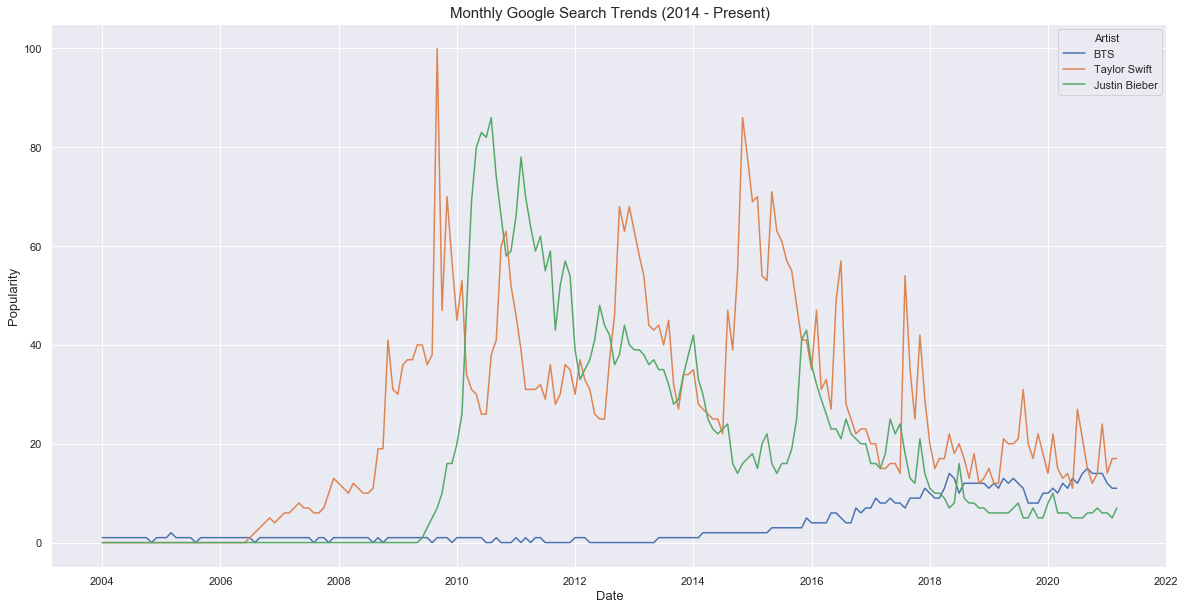

In [39]:
g = sns.lineplot(data = overall_monthly, x = 'date', y = 'Popularity',
                 hue = 'Artist', dashes = False)
g.set_title('Monthly Google Search Trends (2014 - Present)', size = 15)
plt.xlabel("Date", size=13)
plt.ylabel("Popularity", size=13)

plt.savefig('graphs/popularity_all_cat.png', dpi=300)

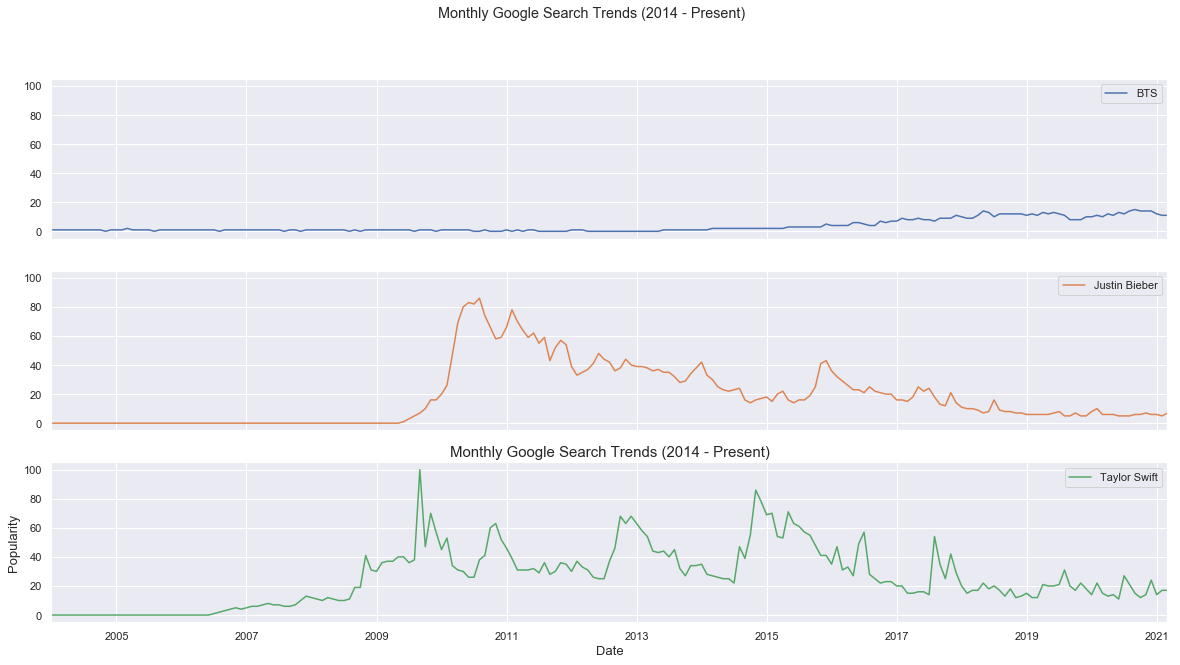

In [21]:
pd.pivot_table(overall_monthly,
               index='date', columns='Artist', values='Popularity'
              ).plot(subplots=True,
                    title = 'Monthly Google Search Trends (2014 - Present)',
                    sharey = True)

plt.title('Monthly Google Search Trends (2014 - Present)', size = 15)
plt.xlabel("Date", size=13)
plt.ylabel("Popularity", size=13)

plt.savefig('graphs/popularity_split_cat.png', dpi=300)

### Timeframe Plotting Popularity

graphs/BTS_2014-08-17_2014-08-31_cat.png


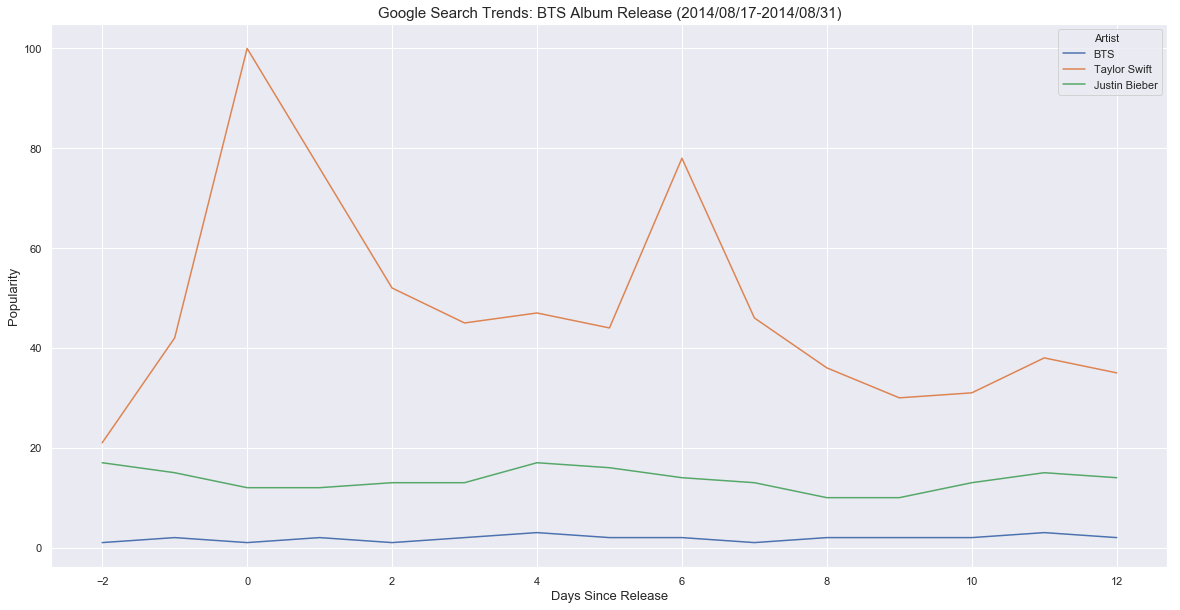

graphs/BTS_2018-05-16_2018-05-30_cat.png


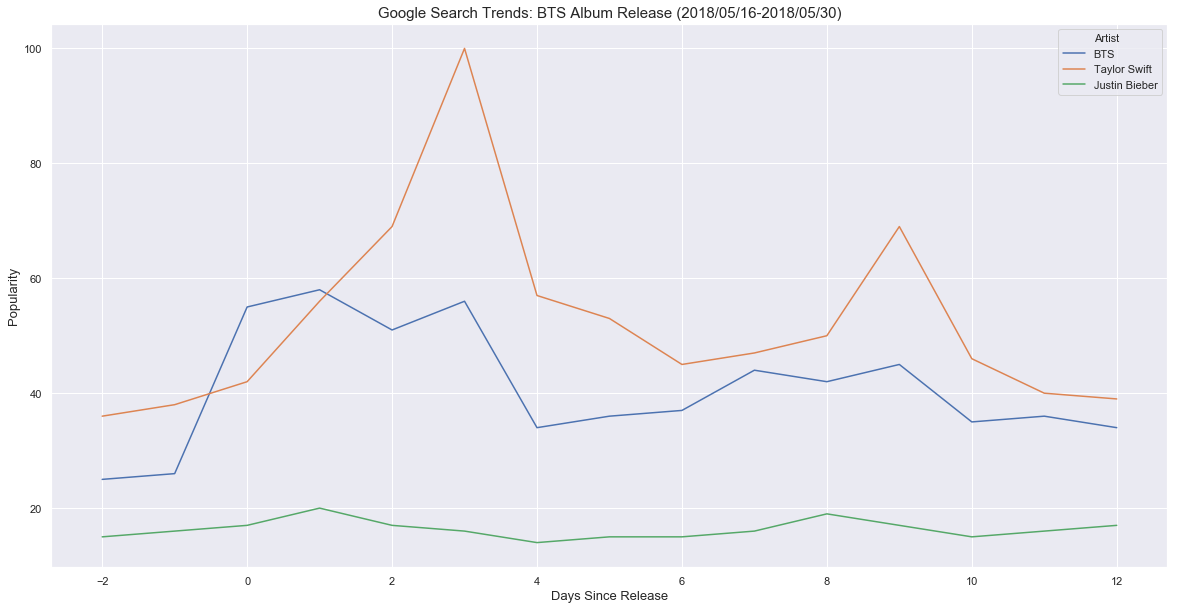

graphs/BTS_2020-11-18_2020-12-02_cat.png


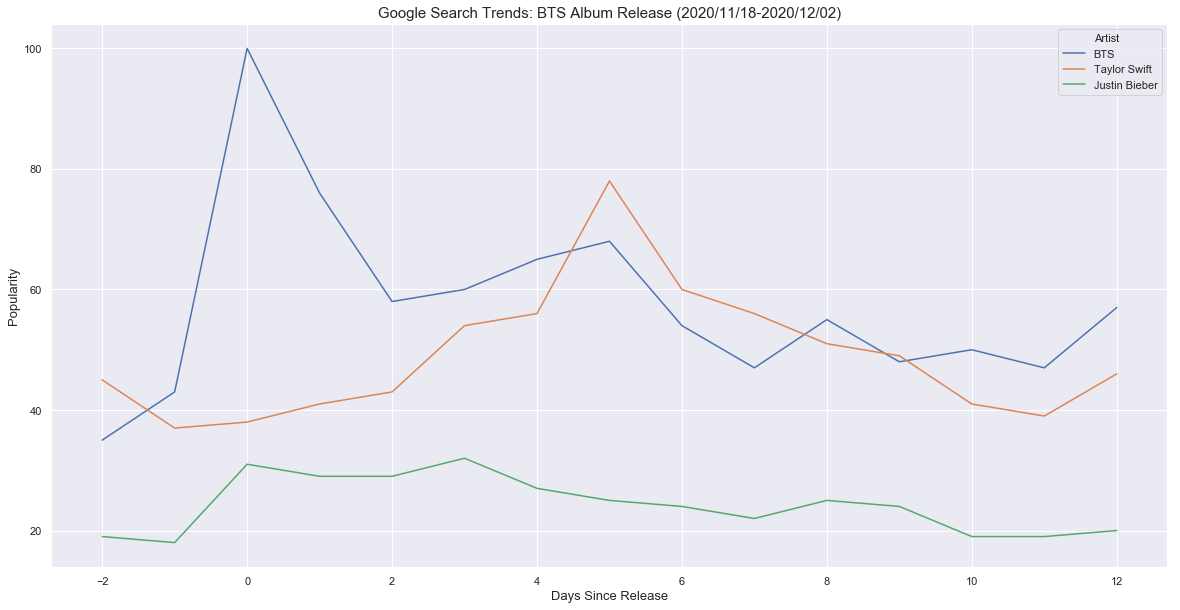

graphs/Taylor Swift_2014-10-25_2014-11-08_cat.png


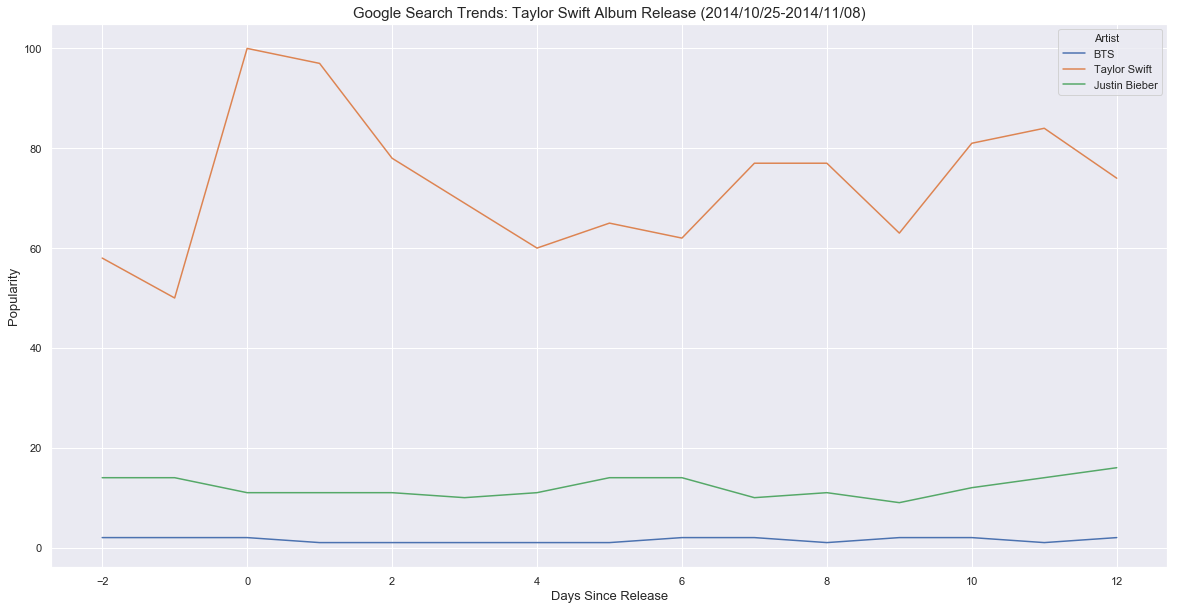

graphs/Taylor Swift_2017-11-08_2017-11-22_cat.png


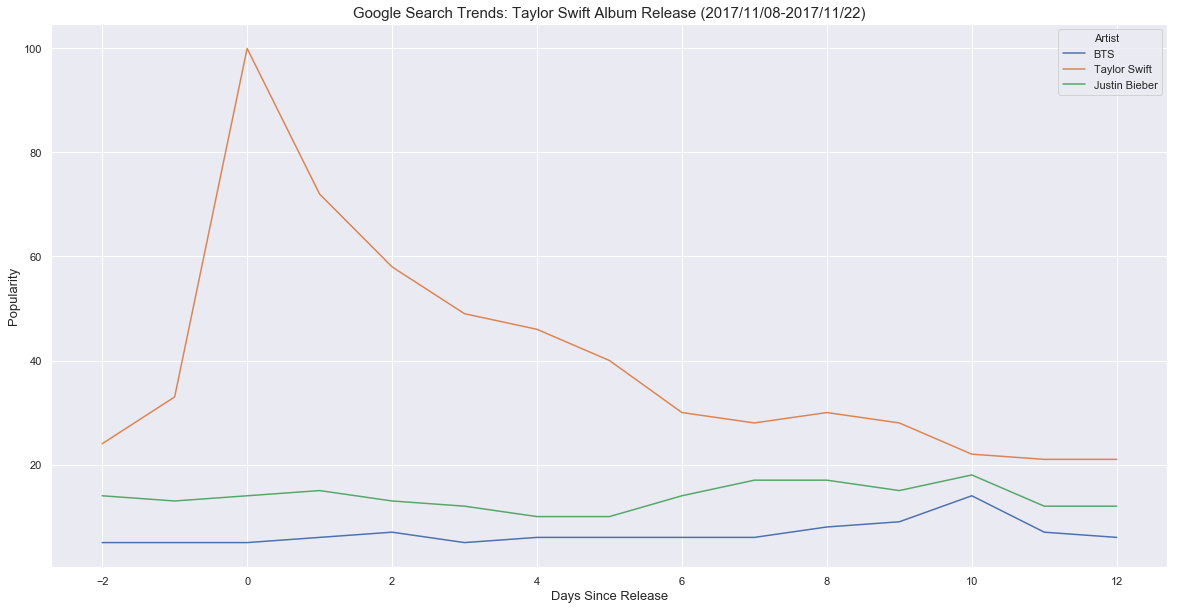

graphs/Taylor Swift_2020-07-22_2020-08-05_cat.png


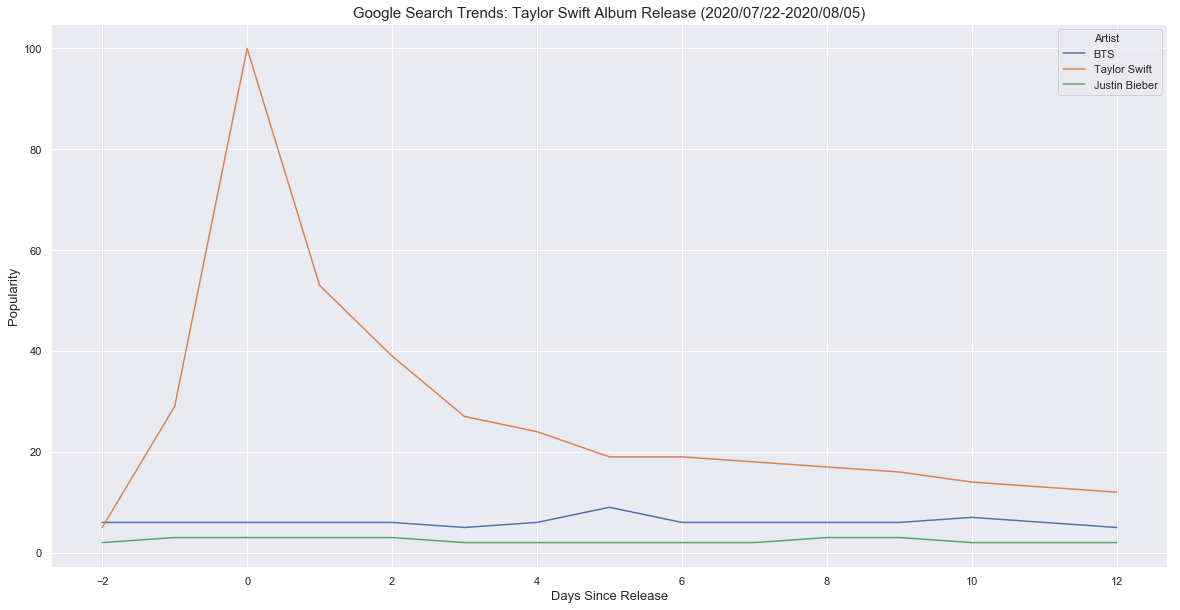

graphs/Justin Bieber_2012-06-13_2012-06-27_cat.png


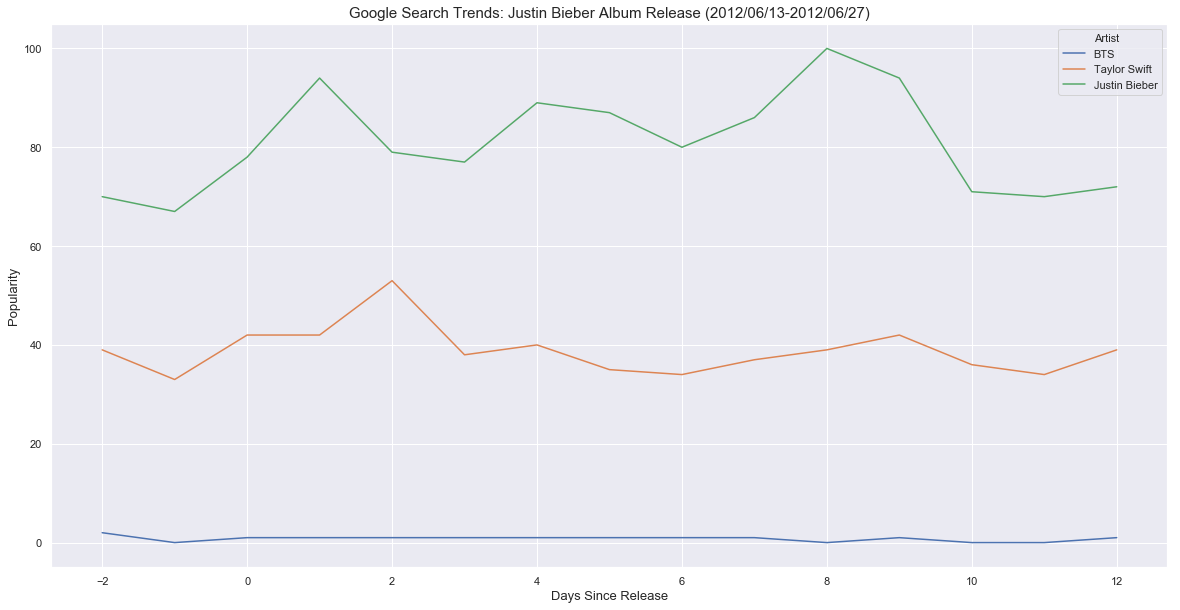

graphs/Justin Bieber_2015-11-11_2015-11-25_cat.png


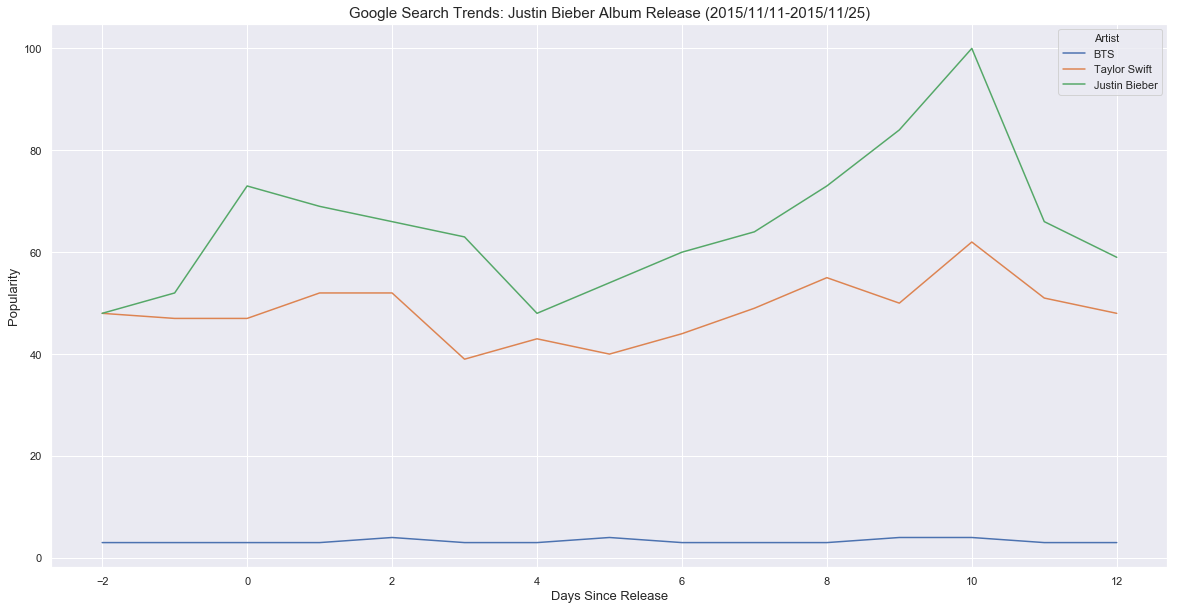

graphs/Justin Bieber_2020-02-12_2020-02-26_cat.png


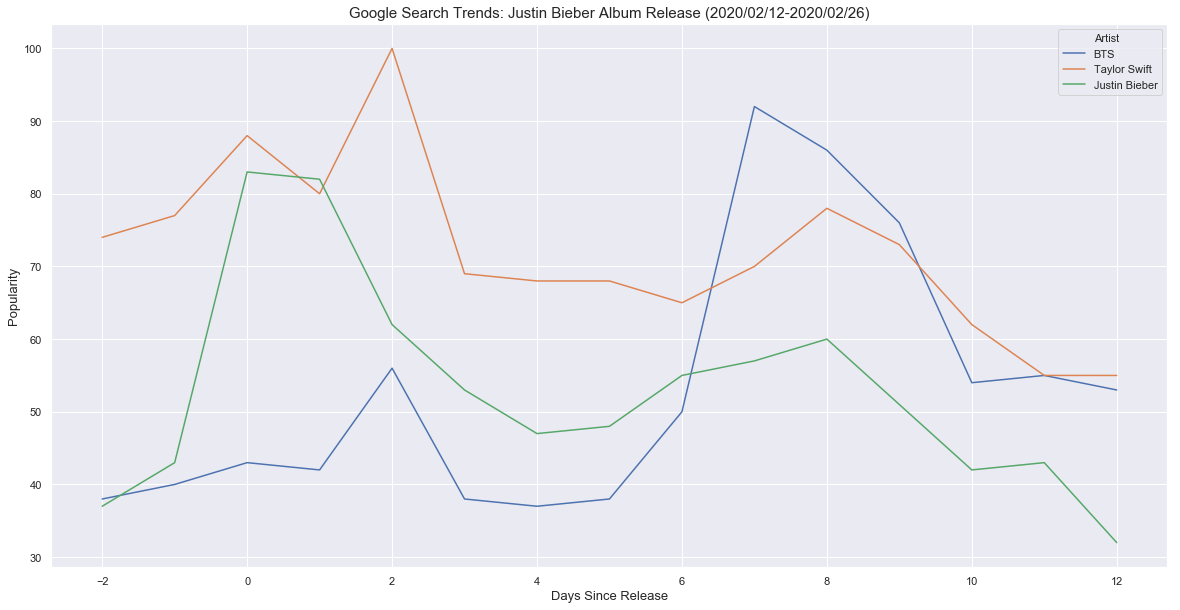

In [40]:
c = 0
df_list = []

for albums in music_timeframes:
    for dates in albums:
        while True:
            try:
                pytrends.build_payload(kw_list = artists, cat = 3, timeframe = dates) 
#                 pytrends.build_payload(kw_list = artists, timeframe = dates) 

                ranged = pytrends.interest_over_time()

                ranged.drop('isPartial', inplace = True, axis = 1)
                ranged.reset_index(inplace = True)

                ranged = ranged.melt(id_vars = ['date'],
                                    var_name = 'Artist',
                                    value_name = 'Popularity')
                df_list.append(ranged)

                #labels

                date_labels = dates.split(' ')

                file_name = 'graphs/' + artist_albums[c] + '_' +\
                date_labels[0] + '_' + date_labels[1] +\
                '_cat.png'
                
                print(file_name)

                date_labels[0] = date_labels[0].replace('-', '/')
                date_labels[1] = date_labels[1].replace('-', '/')


                title_text = 'Google Search Trends: ' + artist_albums[c] +\
                ' Album Release (' + date_labels[0] + '-' + date_labels[1] + ')'

                #plotting
                
                labels = np.arange(-2, 13, 1)
                labels = np.tile(labels, 3)
                
#                 labels = np.arange(-2, 13, 1)

                ranged['Days Since Release'] = labels

                g = sns.lineplot(data = ranged, x = 'Days Since Release', y = 'Popularity',
                         hue = 'Artist', dashes = False)

                #g.xaxis.set_major_locator(ticker.MaxNLocator(nbins = 8))

                plt.title(title_text, size = 15)
                
                plt.xlabel("Days Since Release", size=13)
                plt.ylabel("Popularity", size=13)

                plt.savefig(file_name, dpi=300)

        
#                 g = sns.lineplot(data = ranged, x = 'date', y = 'Popularity',
#                           hue = 'Artist', dashes = False)

#                 g.set(xlabel = 'Days Since Release')
#                 g.set(ylabel = 'Popularity')
                
#                 plt.savefig(file_name, dpi=300)

                plt.show()
                
                break
            except:
                time.sleep(12)
                continue
                
    c += 1
    time.sleep(12)

In [41]:
big_df = pd.DataFrame()
big_df['Artist'] = df_list[0]['Artist']

artist_c = 0
timeframe_c = 1

for i in range(len(df_list)):
    if timeframe_c == 4:
        artist_c += 1
        timeframe_c = 1
        
    col = artist_albums[artist_c] + ' album ' + str(timeframe_c)
    
    big_df[col] = df_list[i]['Popularity']
    
    timeframe_c += 1

In [42]:
days = np.tile(np.arange(-2, 13), 3)
big_df['Day'] = days
big_df

big_df = big_df.rename(columns = {
    'BTS album 1': 'BTS - Dark and Wild',
    'BTS album 2': 'BTS - Love Yourself: Tear',
    'BTS album 3': 'BTS - Be',
    'Taylor Swift album 1': 'Taylor Swift - 1989',
    'Taylor Swift album 2': 'Taylor Swift - Reputation',
    'Taylor Swift album 3': 'Taylor Swift - Folklore',
    'Justin Bieber album 1': 'Justin Bieber - Believe',
    'Justin Bieber album 2': 'Justin Bieber - Purpose',
    'Justin Bieber album 3': 'Justin Bieber - Changes'
})

big_df.head(3)

,Artist,BTS - Dark and Wild,BTS - Love Yourself: Tear,BTS - Be,Taylor Swift - 1989,Taylor Swift - Reputation,Taylor Swift - Folklore,Justin Bieber - Believe,Justin Bieber - Purpose,Justin Bieber - Changes,Day
0,BTS,1,25,35,2,5,6,2,3,38,-2
1,BTS,2,26,43,2,5,6,0,3,40,-1
2,BTS,1,55,100,2,5,6,1,3,43,0


In [43]:
b = big_df.melt(id_vars = ['Artist', 'Day'],
       var_name = 'Artist - Album',
       value_name = 'Popularity')
b.head()

,Artist,Day,Artist - Album,Popularity
0,BTS,-2,BTS - Dark and Wild,1
1,BTS,-1,BTS - Dark and Wild,2
2,BTS,0,BTS - Dark and Wild,1
3,BTS,1,BTS - Dark and Wild,2
4,BTS,2,BTS - Dark and Wild,1


In [44]:
# sns.lineplot(data = b, x = 'Day', y = 'Popularity', hue = 'Artist',
#             ci = None)

# plt.savefig('graphs/all_albums.png', dpi=300)

In [45]:
album1 = pd.concat([b.loc[(b['Artist - Album'] == 'BTS - Dark and Wild') & (b['Artist'] == 'BTS')],
                   b.loc[(b['Artist - Album'] == 'Taylor Swift - 1989') & (b['Artist'] == 'Taylor Swift')],
                   b.loc[(b['Artist - Album'] == 'Justin Bieber - Believe') & (b['Artist'] == 'Justin Bieber')]])

album2 = pd.concat([b.loc[(b['Artist - Album'] == 'BTS - Love Yourself: Tear') & (b['Artist'] == 'BTS')],
                   b.loc[(b['Artist - Album'] == 'Taylor Swift - Reputation') & (b['Artist'] == 'Taylor Swift')],
                   b.loc[(b['Artist - Album'] == 'Justin Bieber - Purpose') & (b['Artist'] == 'Justin Bieber')]])

album3 = pd.concat([b.loc[(b['Artist - Album'] == 'BTS - Be') & (b['Artist'] == 'BTS')],
                   b.loc[(b['Artist - Album'] == 'Taylor Swift - Folklore') & (b['Artist'] == 'Taylor Swift')],
                   b.loc[(b['Artist - Album'] == 'Justin Bieber - Changes') & (b['Artist'] == 'Justin Bieber')]])

In [46]:
album1.groupby('Artist').agg({
    'Popularity': ['mean', 'median', 'count',
                  'max', 'min', 'std', 'var', 'skew', pd.DataFrame.kurt]
})

Popularity                                               \
                    mean median count  max min        std         var   
Artist                                                                  
BTS             1.866667      2    15    3   1   0.639940    0.409524   
Justin Bieber  80.933333     79    15  100  67  10.257169  105.209524   
Taylor Swift   73.000000     74    15  100  50  14.071247  198.000000   

                                   
                   skew      kurt  
Artist                             
BTS            0.103431 -0.126680  
Justin Bieber  0.394509 -0.995321  
Taylor Swift   0.442482 -0.206262

In [47]:
album2.groupby('Artist').agg({
    'Popularity': ['mean', 'median', 'count',
                  'max', 'min', 'std', 'var', 'skew', pd.DataFrame.kurt]
})

Popularity                                               \
                    mean median count  max min        std         var   
Artist                                                                  
BTS            40.933333     37    15   58  25  10.409245  108.352381   
Justin Bieber  65.266667     64    15  100  48  13.796825  190.352381   
Taylor Swift   40.133333     30    15  100  21  22.206391  493.123810   

                                   
                   skew      kurt  
Artist                             
BTS            0.273325 -0.889850  
Justin Bieber  1.097991  1.729579  
Taylor Swift   1.680929  2.781842

In [48]:
album3.groupby('Artist').agg({
    'Popularity': ['mean', 'median', 'count',
                  'max', 'min', 'std', 'var', 'skew', pd.DataFrame.kurt]
})
#pd.Series.mode,,, issue with mode.. 

Popularity                                               \
                    mean median count  max min        std         var   
Artist                                                                  
BTS            57.533333     55    15  100  35  15.638171  244.552381   
Justin Bieber  53.000000     51    15   83  32  14.574930  212.428571   
Taylor Swift   27.000000     19    15  100   5  23.400244  547.571429   

                                   
                   skew      kurt  
Artist                             
BTS            1.427903  3.070625  
Justin Bieber  0.944887  0.670387  
Taylor Swift   2.478026  6.957311

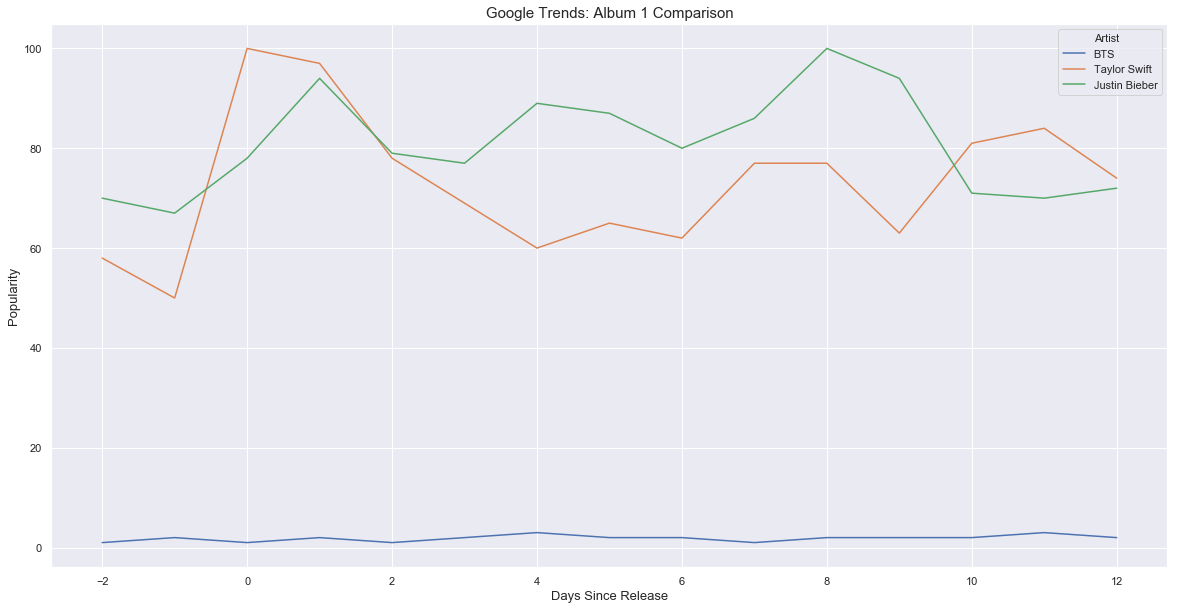

In [49]:
a = sns.lineplot(data = album1, x = 'Day', y = 'Popularity', hue = 'Artist')

plt.title('Google Trends: Album 1 Comparison', size = 15)              
plt.xlabel("Days Since Release", size=13)
plt.ylabel("Popularity", size=13)

plt.savefig('graphs/album1_cat.png', dpi=300)

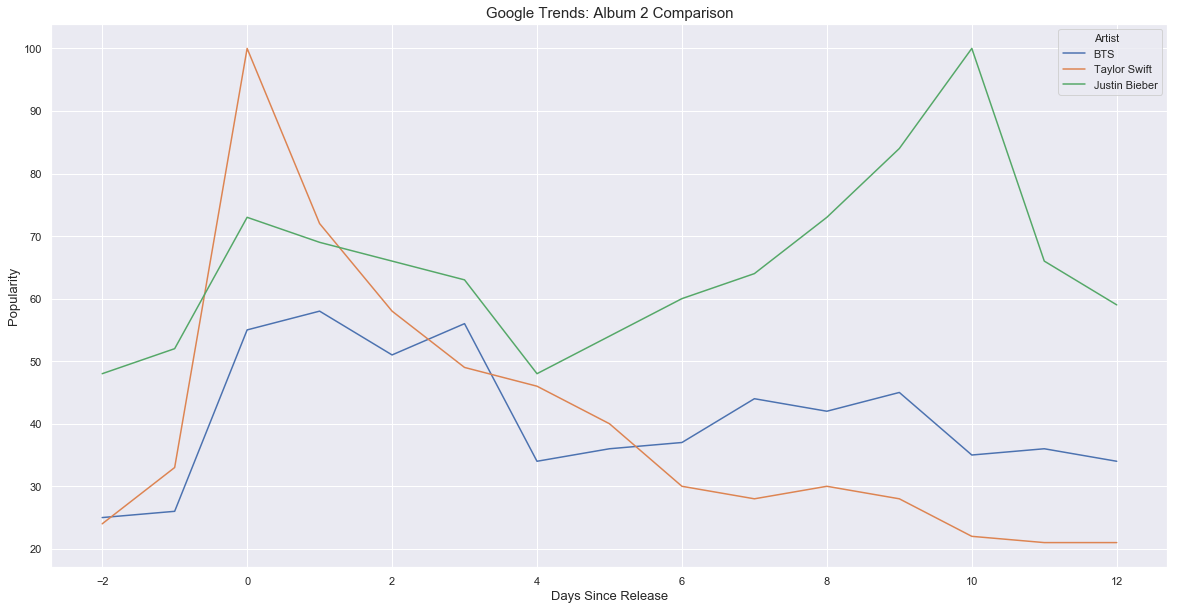

In [50]:
a = sns.lineplot(data = album2, x = 'Day', y = 'Popularity', hue = 'Artist',
            ci = None)

plt.title('Google Trends: Album 2 Comparison', size = 15)              
plt.xlabel("Days Since Release", size=13)
plt.ylabel("Popularity", size=13)

plt.savefig('graphs/album2_cat.png', dpi=300)

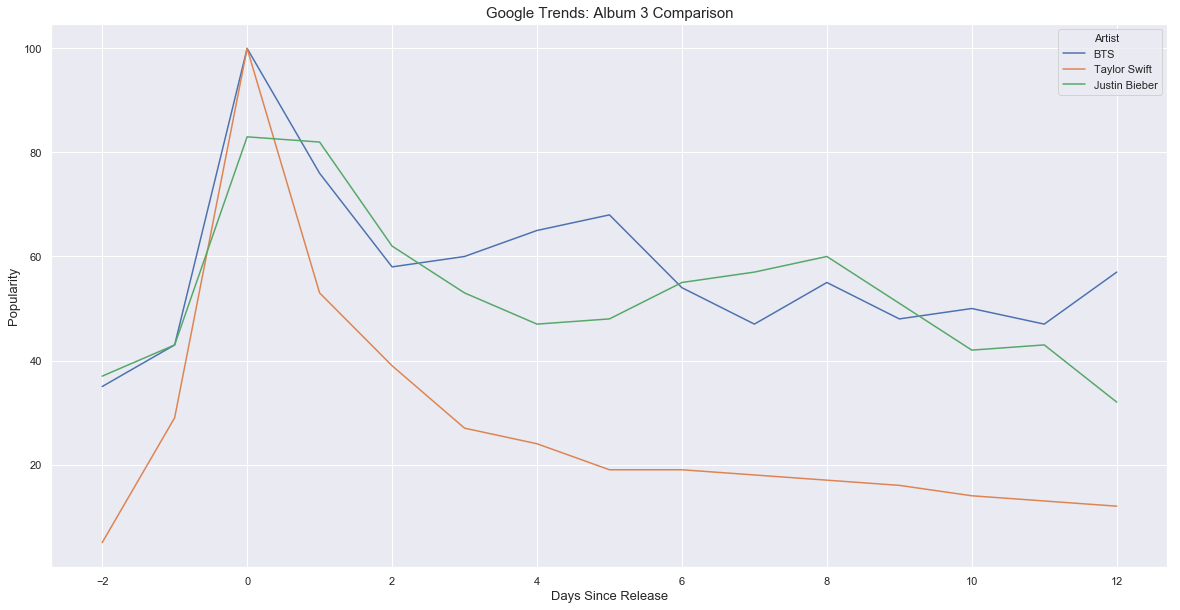

In [51]:
a = sns.lineplot(data = album3, x = 'Day', y = 'Popularity', hue = 'Artist',
            ci = None)

plt.title('Google Trends: Album 3 Comparison', size = 15)              
plt.xlabel("Days Since Release", size=13)
plt.ylabel("Popularity", size=13)

plt.savefig('graphs/album3_cat.png', dpi=300)

## Plotly Plotting - Popularity

### Overall Monthly Popularity

In [ ]:
#plot monthly search popularity for entire time frame available
px.line(overall_monthly, x = 'date', y = 'Popularity', color = 'Artist',
        title = 'Monthly Google Search Trends (2014 - Present)')

In [ ]:
px.area(overall_monthly, x = 'date', y = 'Popularity',
        title = 'Monthly Google Search Trends', facet_col = 'Artist',
       facet_col_wrap = 2)

### Timeframe Plotting Popularity

In [ ]:
c = 0

for albums in music_timeframes:
    for dates in albums:
        pytrends.build_payload(kw_list = artists, cat = 3, timeframe = dates) 
        
        ranged = pytrends.interest_over_time()

        ranged.drop('isPartial', inplace = True, axis = 1)
        ranged.reset_index(inplace = True)

        ranged = ranged.melt(id_vars = ['date'],
                            var_name = 'Artist',
                            value_name = 'Popularity')
        
        #labels
        
        date_labels = dates.split(' ')
        date_labels[0] = date_labels[0].replace('-', '/')
        date_labels[1] = date_labels[1].replace('-', '/')
        
        title_text = 'Google Search Trends: ' + artist_albums[c] +\
        ' Album Release (' + date_labels[0] + '-' + date_labels[1] + ')'
        
        
        title_text = 'Google Search Trends: ' + artist_albums[c] +\
        ' Album Release (' + dates + ')'
        
        fig = px.line(ranged, x = 'date', y = 'Popularity',
                      color = 'Artist', title = title_text)   
        
        fig.show()
        
    c += 1

## Plotly Plotting - Regions

In [ ]:
# px.choropleth(regions_w_code, locations="countryCode",
#               color="Taylor Swift",
#               #hover_name="geoName", # column to add to hover information
#               color_continuous_scale=px.colors.sequential.Plasma)

### Related Searches

Let's find the related queries and topics for each artist during their album releases.

In [36]:
bts_topics = pd.DataFrame(columns = ['value','topic_title', 'topic_type', 'date'])
bts_queries = pd.DataFrame(columns = ['value','query','date'])

for bts in bts_timeframes:
    while True:
        try:

            pytrends.build_payload(kw_list = ['BTS'], cat = 3, timeframe = bts)

            #topics
            topics = pytrends.related_topics()

            topt = topics['BTS']['top'][['value', 'topic_title', 'topic_type']]
            topt['date'] = bts

            bts_topics = pd.concat([bts_topics, topt])
            time.sleep(6)

            #queries
            queries = pytrends.related_queries()

            topq = queries['BTS']['top']

            topq['date'] = bts

            bts_queries = pd.concat([bts_queries, topq])
            break
        except:
            time.sleep(12)
            continue

/Users/Casey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
ts_topics = pd.DataFrame(columns = ['value','topic_title', 'topic_type','date'])
ts_queries = pd.DataFrame(columns = ['value','query','date'])

for ts in ts_timeframes:
    while True:
        try:

            pytrends.build_payload(kw_list = ['Taylor Swift'], cat = 3, timeframe = ts)
    
            #topics
            topics = pytrends.related_topics()

            topt = topics['Taylor Swift']['top'][['value', 'topic_title', 'topic_type']]
            topt['date'] = ts

            ts_topics = pd.concat([ts_topics, topt])
            time.sleep(6)

            #queries
            queries = pytrends.related_queries()

            topq = queries['Taylor Swift']['top']
            topq['date'] = ts

            ts_queries = pd.concat([ts_queries, topq])

            break
        except:
            time.sleep(12)
            continue

/Users/Casey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
jb_topics = pd.DataFrame(columns = ['value','topic_title', 'topic_type','date'])
jb_queries = pd.DataFrame(columns = ['value','query','date'])

for jb in jb_timeframes:
    while True:
        try:

            pytrends.build_payload(kw_list = ['Justin Bieber'], cat = 3, timeframe = jb)
    
            #topics
            topics = pytrends.related_topics()

            topt = topics['Justin Bieber']['top'][['value', 'topic_title', 'topic_type']]
            topt['date'] = jb

            jb_topics = pd.concat([jb_topics, topt])
            time.sleep(12)

            #queries
            queries = pytrends.related_queries()

            topq = queries['Justin Bieber']['top']
            topq['date'] = jb

            jb_queries = pd.concat([jb_queries, topq])

            break
        except:
            time.sleep(12)
            continue

/Users/Casey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [109]:
artist_words = ['bts', 'taylor', 'swift', 'justin', 'bieber']

def most_common_terms(related):
    try:
        split_search = related['query'].apply(lambda x: x.lower().split())
        com = pd.Series([x for item in split_search\
                         for x in item if x not in stopwords.words()\
                        and x not in artist_words]).value_counts()
        com = com.to_frame('Related Query Term Count')
        
        return com.head(5)
    except:
        split_search = related['topic_title'].apply(lambda x: x.lower().split())
        com = pd.Series([x for item in split_search\
                         for x in item if x not in stopwords.words()\
                        and x not in artist_words]).value_counts()
        com = com.to_frame('Related Topic Term Count')
        
        return com.head(5)

In [110]:
all_related = [bts_queries, bts_topics,
              ts_queries, ts_topics,
              jb_queries, jb_topics]

In [111]:
for rel in all_related:
    display(most_common_terms(rel))

,Related Query Term Count
life,10
lagu,10
love,9
goes,8
lyrics,7


,Related Topic Term Count
awards,4
music,4
language,4
love,4
jungkook,3


,Related Query Term Count
lyrics,11
album,10
1989,6
folklore,6
reputation,6


,Related Topic Term Count
tour,5
reputation,4
1989,3
shake,2
swift's,2


,Related Query Term Count
selena,10
album,9
gomez,9
lyrics,9
love,7


,Related Topic Term Count
love,11
music,8
corden,6
james,6
purpose,6
